In [1]:
# Import needed packages for analysis
import os

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn.preprocessing import StandardScaler

import cfl.util.brain_util as BU
import cfl.util.brain_vis as BV
from cfl.util import fear_mice_functions as fm
from cfl.util.fear_mice_functions import get_global_values


mri_dir, mri_dims, affine, dir_labels = get_global_values()

# load the non-linear mask template
nl_mask_path = os.path.join('PTSD_Data_Share/templates\MuseTemplate_nonlinear_mask.nii')
nl_mask = BU.load_brain(nl_mask_path, ori='RPS')
nolin_mask_vec = BU.flatten(nl_mask)

In [2]:
# load response data 
Y = pd.read_pickle('Y.pkl')

# # load all the images 
X = np.load('smooth_X_paper_sigma.npy')


In [3]:
folder_path = os.path.join('npy_files', 'smooth')

In [4]:
# Uncomment this block to run the regression on all of the X data 
data_id = 'smooth_X_'

indices_dir = fm.timepoint_indices_dir(Y)

# load smoooth fear minus pre-fear MRIs 
X_diffs = X[indices_dir['Fear']] - X[indices_dir['PreF']]

# load fear minus pre-fear response data 
Y_diffs = Y.PerLight[indices_dir['Fear']].to_numpy() - Y.PerLight[indices_dir['PreF']].to_numpy()
Y_diffs = np.expand_dims(Y_diffs, -1) #expand to make it 2d


In [5]:
# # # Uncomment this block to run the regression on only WT data 
# data_id = 'smooth_X_WT_'

# geno_indices_dir = fm.geno_time_indices_dir(Y) 

# # smooth fear - pre-fear WT MRIs 
# X_diffs = X[geno_indices_dir['Fear_WT']] - X[geno_indices_dir['PreF_WT']]

# # load fear minus pre-fear response data 
# Y_diffs = Y.PerLight[geno_indices_dir['Fear_WT']].to_numpy() - Y.PerLight[geno_indices_dir['PreF_WT']].to_numpy()
# Y_diffs = np.expand_dims(Y_diffs, -1) #expand to make it 2d


In [6]:
# center the data 
X_diffs_t = StandardScaler().fit_transform(X_diffs)
Y_diffs_t = StandardScaler().fit_transform(Y_diffs)

 - Calculate the regressions for (fear - pre-fear) MRI activation & (fear - pre-fear) Response (time spent in the light)   

- Voxel-wise across all the voxels of the brain    

- 20 pairs of data (1 for each mouse)   

- Using Gaussian smoothed brain data    

In [7]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold


In [8]:
def threeD_index_to_flat(i, dim): 
    return i[0] * (dim[1]*dim[2]) + i[1] * dim[2] + i[2]

def do_regression(X_diffs, Y_diffs, mask, reg_model):
    '''
    X_diffs (array): np array with dim (n_samples, n_voxels)
    Y_diffs (array): np.array with dim (n_sampels, 1)
    reg_model : a regression model 
    '''
    n_voxels = X_diffs.shape[1]

    # return values will be stored in these arrays 
    coefs= np.zeros(n_voxels) 
    alphas = np.zeros(n_voxels)

    #do the regression, voxelwise
    for voxel in tqdm(range(n_voxels)): 
        if mask[voxel] != 0: #skip the masked voxels

            #make the activations for a single voxel into 2D array
            x = np.expand_dims(X_diffs[:, voxel], -1)

            reg_model.fit(X=x, y=Y_diffs)
            coefs[voxel] = reg_model.coef_
            alphas[voxel] = reg_model.alpha_
    return coefs, alphas

## Ridge Regression

In [9]:
# # define ridge regression model 
# # test alpha values from 0 to 5
# ridge_model = RidgeCV(alphas=np.arange(0.1, 5, 0.25), fit_intercept=False)

# ridge_coef, ridge_alpha = do_regression(X_diffs_t, Y_diffs_t, nolin_mask_vec, ridge_model)

In [10]:
# np.save(os.path.join(folder_path, data_id + "ridge_reg_coefs.npy"), ridge_coef)
# np.save(os.path.join(folder_path, data_id + "ridge_reg_alpha.npy"), ridge_alpha)

# fm.save_as_nifti(ridge_coef, data_id+"ridge_reg_coefs.nii", mri_dims, affine)
# fm.save_as_nifti(ridge_alpha,  data_id+"ridge_reg_alpha.nii", mri_dims, affine)

In [11]:
ridge_coef = np.load(os.path.join(folder_path, data_id + "ridge_reg_coefs.npy"))
ridge_alpha = np.load(os.path.join(folder_path, data_id + "ridge_reg_alpha.npy"))

In [12]:
np.unique(ridge_alpha)

array([0.  , 0.1 , 0.35, 0.6 , 0.85, 1.1 , 1.35, 1.6 , 1.85, 2.1 , 2.35,
       2.6 , 2.85, 3.1 , 3.35, 3.6 , 3.85, 4.1 , 4.35, 4.6 , 4.85])

In [13]:
# BV.plot_interactive_panels(ridge_coef, mri_dims, nolin_mask_vec, figsize=(12, 3), std_scale='std', dir_labels=dir_labels, column_titles=["Ridge Regression"])

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=123), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=199), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=81), Output()…

In [14]:
from sklearn.linear_model import LinearRegression

def graph_one_voxel_scatter(voxel_loc, reg_coefs, reg_alpha, X_diffs, Y_diffs, mri_dims, reg_type="Ridge"): 
    '''voxel location is a 3-tuple/list/array that gives 3-D index of voxel location 
    in MRI 

    reg_coefs is an array with dims (mri_dims) that has the coefficients for a voxel-wise regression. 
    reg_ints is an array with dims (mri_dims) that has the y-intercepts from the same voxel-wise regression
    '''

    flat_vox_ind = threeD_index_to_flat(voxel_loc, mri_dims)

    # scatter plot the points 
    plt.scatter(X_diffs[:, flat_vox_ind], Y_diffs)
    
    # graph the ridge regression line
    coef = reg_coefs[flat_vox_ind]
    yint = 0
    plt.axline(xy1=(0, yint), slope=coef)

    # compare the linear regression line 
    lr = LinearRegression(fit_intercept=False).fit(np.expand_dims(X_diffs[:, flat_vox_ind], -1), Y_diffs)
    # plt.axline(xy1=(0, lr.intercept_[0]), slope=lr.coef_[0][0], color="red", linestyle=(0, (5, 5)))
    plt.axline(xy1= (0, 0), slope=lr.coef_[0][0], color="red", linestyle=(0, (5, 5)))

    plt.suptitle("Fear - PreF MRI activity vs response values")
    plt.xlabel("Normalized Difference in MRI Activation")
    plt.ylabel("Normalized Difference in time spent in light")
    plt.show()

    # print('Ridge regression: y={slope}x + {int}, Lambda={lamba}\n LS regression: y={lsslope}x + {lsint} \n Blue line is regression of interest; red dotted line is least squares regression, for comparison'.format(slope=coef, int=yint, lamba=rg_alpha_unflat[voxel_loc], lsslope=lr.coef_[0][0], lsint=lr.intercept_[0]))]
    print('{type} regression: y={slope}x , Lambda={lamba}\n LS regression: y={lsslope}x \n Blue line is regression of interest; red dotted line is least squares regression, for comparison'.format(slope=coef, lamba=np.around(reg_alpha[flat_vox_ind], 2), lsslope=lr.coef_[0][0], type=reg_type))

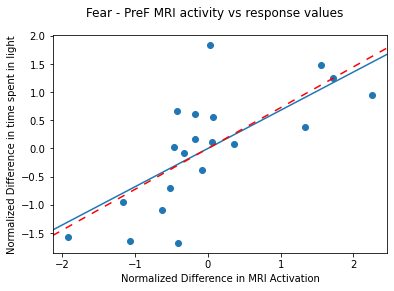

Ridge regression: y=0.6783098768070781x , Lambda=1.35
 LS regression: y=0.7240957934915565x 
 Blue line is regression of interest; red dotted line is least squares regression, for comparison


In [15]:
graph_one_voxel_scatter((86, 93, 18), ridge_coef, ridge_alpha, X_diffs_t, Y_diffs_t, mri_dims)

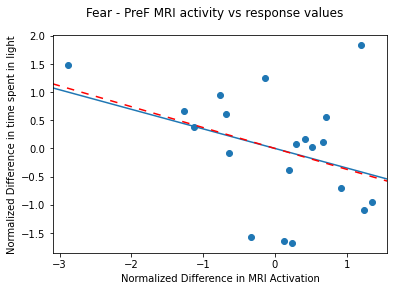

Ridge regression: y=-0.3470320321951177x , Lambda=1.35
 LS regression: y=-0.3704566943682908x 
 Blue line is regression of interest; red dotted line is least squares regression, for comparison


In [16]:
graph_one_voxel_scatter((49, 104, 53), ridge_coef, ridge_alpha, X_diffs_t, Y_diffs_t, mri_dims)

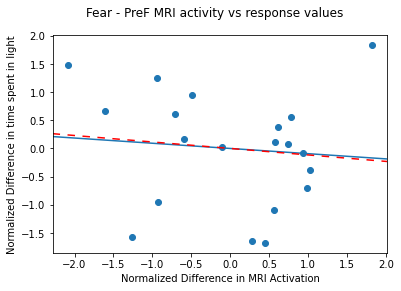

Ridge regression: y=-0.09252880110144002x , Lambda=4.85
 LS regression: y=-0.11496703536853912x 
 Blue line is regression of interest; red dotted line is least squares regression, for comparison


In [17]:
graph_one_voxel_scatter((50, 99, 60), ridge_coef, ridge_alpha, X_diffs_t, Y_diffs_t, mri_dims)

# Laso Regression 

In [18]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

In [19]:
# # test alpha values from 0 to 1 
# lasso_model = LassoCV(alphas=np.arange(0.1, 1, 0.1))

In [20]:
# lasso_coef, lasso_alphas = do_regression(X_diffs_t, Y_diffs_t, nolin_mask_vec, lasso_model)


In [21]:
# np.save(os.path.join(folder_path, data_id + "lasso_reg_coefs.npy"), lasso_coef)
# np.save(os.path.join(folder_path, data_id + "lasso_reg_alpha.npy"), lasso_alphas)

# fm.save_as_nifti(lasso_coef, data_id+"lasso_reg_coefs.nii", mri_dims, affine)
# fm.save_as_nifti(lasso_alphas, data_id+"lasso_reg_alphas.nii", mri_dims, affine)

In [22]:
lasso_coef = np.load(os.path.join(folder_path, data_id + "lasso_reg_coefs.npy"))
lasso_alphas = np.load(os.path.join(folder_path, data_id + "lasso_reg_alpha.npy"))

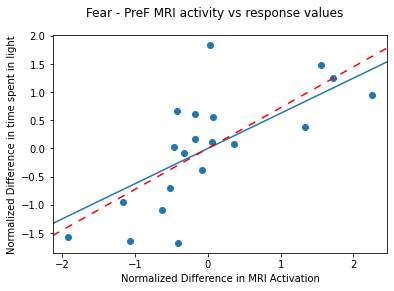

Lasso regression: y=0.6240957934915565x , Lambda=0.1
 LS regression: y=0.7240957934915565x 
 Blue line is regression of interest; red dotted line is least squares regression, for comparison


In [23]:
graph_one_voxel_scatter((86, 93, 18), lasso_coef, lasso_alphas, X_diffs_t, Y_diffs_t, mri_dims, "Lasso")

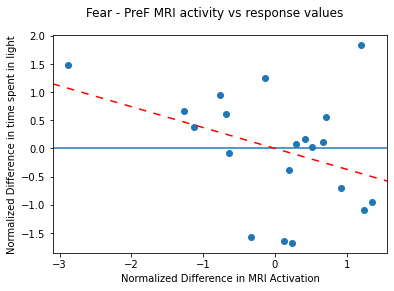

Lasso regression: y=-0.0x , Lambda=0.9
 LS regression: y=-0.3704566943682908x 
 Blue line is regression of interest; red dotted line is least squares regression, for comparison


In [24]:
graph_one_voxel_scatter((49, 104, 53), lasso_coef, lasso_alphas, X_diffs_t, Y_diffs_t, mri_dims, "Lasso")

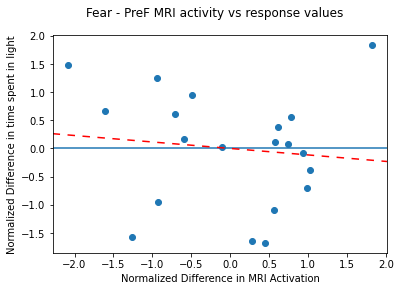

Lasso regression: y=-0.0x , Lambda=0.9
 LS regression: y=-0.11496703536853912x 
 Blue line is regression of interest; red dotted line is least squares regression, for comparison


In [25]:
graph_one_voxel_scatter((50, 99, 60), lasso_coef, lasso_alphas, X_diffs_t, Y_diffs_t, mri_dims, "Lasso")

# Decision Tree 


In [26]:
def do_dec_tree(X_diffs, Y_diffs, mask, max_depth=None):
    '''
    X_diffs (array): np array with dim (n_samples, n_voxels)
    Y_diffs (array): np.array with dim (n_sampels, 1)
    '''
    dec_tree = DecisionTreeRegressor(max_depth=max_depth)

    n_voxels = X_diffs.shape[1]

    # return values will be stored in these arrays 
    fitted_mods = []
    feat_imps = np.zeros(n_voxels)
    alphas = np.zeros(n_voxels)

    #do the regression, voxelwise
    for voxel in tqdm(range(n_voxels)): 
        if mask[voxel] != 0: #skip the masked voxels

            #make the activations for a single voxel into 2D array
            x = np.expand_dims(X_diffs[:, voxel], -1)

            dec_tree.fit(X=x, y=Y_diffs)
            fitted_mods.append(dec_tree)
            feat_imps[voxel] = dec_tree.feature_importances_
        else: 
            fitted_mods.append(np.nan)
    return fitted_mods, feat_imps

In [27]:
from sklearn.tree import DecisionTreeRegressor

braintree = DecisionTreeRegressor()
braintree.fit(X_diffs, Y_diffs)

DecisionTreeRegressor()

[Text(163.0706896551724, 201.90857142857143, 'X[1252353] <= -42.677\nmse = 0.03\nsamples = 20\nvalue = -0.195'),
 Text(86.58620689655172, 170.84571428571428, 'X[1109236] <= 77.654\nmse = 0.007\nsamples = 7\nvalue = -0.392'),
 Text(46.179310344827584, 139.78285714285715, 'X[862618] <= 25.163\nmse = 0.002\nsamples = 4\nvalue = -0.329'),
 Text(23.089655172413792, 108.72, 'X[1680704] <= 24.946\nmse = 0.0\nsamples = 2\nvalue = -0.37'),
 Text(11.544827586206896, 77.65714285714284, 'mse = 0.0\nsamples = 1\nvalue = -0.358'),
 Text(34.63448275862069, 77.65714285714284, 'mse = -0.0\nsamples = 1\nvalue = -0.382'),
 Text(69.26896551724138, 108.72, 'X[1070384] <= -101.518\nmse = 0.001\nsamples = 2\nvalue = -0.288'),
 Text(57.72413793103448, 77.65714285714284, 'mse = 0.0\nsamples = 1\nvalue = -0.26'),
 Text(80.81379310344828, 77.65714285714284, 'mse = -0.0\nsamples = 1\nvalue = -0.316'),
 Text(126.99310344827586, 139.78285714285715, 'X[1439359] <= 128.745\nmse = 0.0\nsamples = 3\nvalue = -0.476'),
 

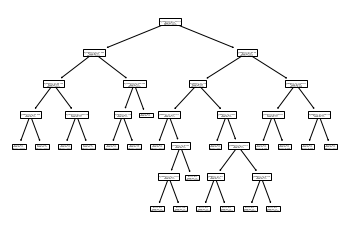

In [28]:
from sklearn import tree 
tree.plot_tree(braintree) 